### `Basic setting`

In [1]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print("sklearn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import tensorflow as tf
print("TF version: ", tf.__version__)
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

sklearn version:  1.0.2
TF version:  2.8.0
1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
np.random.seed(42)


In [3]:
# check GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16753999655061887608
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9879683072
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 689270035654922212
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

### `Load dataset (by_merge)`

In [4]:
# Hyper parameter setting
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.15
LEARNING_RATE = 0.0001
PATIENCE = 10
MIN_LEARNING_RATE = 0.00001
DECAY_FACTOR = 0.2
DENSE_LAYER_ACTIVATION = 'elu'
FINAL_LAYER_ACTIVATION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS = ['accuracy']
optimizer = Adam(learning_rate=LEARNING_RATE)

CHECK_POINT_BALANCE = 'Best_points_densenet.h'

### `Load dataset (by_balanced)`

In [5]:
# 데이터 불러오기
testing_set_balance = pd.read_csv('emnist-balanced-test.csv')
training_set_balance = pd.read_csv('emnist-balanced-train.csv')


# 훈련 데이터와 레이블 추출
train_y_balance = np.array(training_set_balance.iloc[:, 0].values)
train_x_balance = np.array(training_set_balance.iloc[:, 1:].values)

# 테스트 데이터와 레이블 추출
test_y_balance = np.array(testing_set_balance.iloc[:, 0].values)
test_x_balance = np.array(testing_set_balance.iloc[:, 1:].values)

# 데이터 정규화
train_x_balance = train_x_balance / 255.0
test_x_balance = test_x_balance / 255.0

# 이미지 크기 재조정 (데이터 차원 변경)
images_height = 28
images_width = 28
train_x_balance = train_x_balance.reshape(train_x_balance.shape[0], images_height, images_width, 1)
test_x_balance = test_x_balance.reshape(test_x_balance.shape[0], images_height, images_width, 1)

# 클래스 수 = 47
number_of_classes = 47

# 레이블 원-핫 인코딩
train_y_balance = tf.keras.utils.to_categorical(train_y_balance, number_of_classes)
test_y_balance = tf.keras.utils.to_categorical(test_y_balance, number_of_classes)

#VALIDATION_SPLIT = 0.15
train_x_balance, val_x_balance, train_y_balance, val_y_balance = train_test_split(train_x_balance, train_y_balance, 
                                                                              test_size=VALIDATION_SPLIT, random_state=42)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Input,MaxPooling2D, Dense, Flatten ,Activation ,  BatchNormalization , Dropout ,AveragePooling2D
from tensorflow.keras.models import Model
from functools import partial


#### Training PersonalModelwith bybalanced dataset

In [7]:
# Define Densenet
model = tf.keras.Sequential([
    Conv2D(16, kernel_size=(5, 5), activation=DENSE_LAYER_ACTIVATION, input_shape=(28, 28, 1), padding='same'),
    AveragePooling2D(),
    # Conv2D(16, kernel_size=(3, 3), activation=DENSE_LAYER_ACTIVATION, padding='same'),
    # BatchNormalization(),
    # AveragePooling2D(),
    Conv2D(32, kernel_size=(5, 5), activation=DENSE_LAYER_ACTIVATION, padding='same'),
    BatchNormalization(),
    AveragePooling2D(),
    Conv2D(64, kernel_size=(5, 5), activation=DENSE_LAYER_ACTIVATION, padding='same'),
    BatchNormalization(),
    AveragePooling2D(),
    Conv2D(128, kernel_size=(5, 5), activation=DENSE_LAYER_ACTIVATION, padding='same'),
    BatchNormalization(),
    AveragePooling2D(pool_size=(1, 1)),
    Flatten(),
    Dense(128, activation=DENSE_LAYER_ACTIVATION),
    Dropout(0.5),
    Dense(number_of_classes, activation=FINAL_LAYER_ACTIVATION)
])

#model.summary()

In [8]:
# 모델 컴파일
#LOSS_FUNCTION = 'categorical_crossentropy'
#LEARNING_RATE = 0.001
#METRICS = ['accuracy']

model.compile(optimizer=optimizer,
            loss=LOSS_FUNCTION,
            metrics=METRICS)

# 콜백 설정
#DECAY_FACTOR = 0.2
#PATIENCE = 3
#MIN_LEARNING_RATE = 0.0001

callbacks_balance = [
    ModelCheckpoint(CHECK_POINT_BALANCE, verbose=1, save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=PATIENCE, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=DECAY_FACTOR, min_lr=MIN_LEARNING_RATE)
]


In [9]:
start_time = time.time()  # 학습 시작 시간

# 모델 학습
history_balance = model.fit(train_x_balance, train_y_balance, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                                validation_data=(val_x_balance, val_y_balance), callbacks=callbacks_balance)

training_time = time.time() - start_time

Epoch 1/100
2997/2997 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.5463
Epoch 1: val_accuracy improved from -inf to 0.76525, saving model to Best_points_densenet.h
INFO:tensorflow:Assets written to: Best_points_densenet.h\assets
2997/2997 [==============================] - 10s 3ms/step - loss: 1.6085 - accuracy: 0.5463 - val_loss: 0.7619 - val_accuracy: 0.7652 - lr: 1.0000e-04
Epoch 2/100
2980/2997 [============================>.] - ETA: 0s - loss: 0.8920 - accuracy: 0.7269
Epoch 2: val_accuracy improved from 0.76525 to 0.81696, saving model to Best_points_densenet.h
INFO:tensorflow:Assets written to: Best_points_densenet.h\assets
2997/2997 [==============================] - 7s 2ms/step - loss: 0.8916 - accuracy: 0.7271 - val_loss: 0.5515 - val_accuracy: 0.8170 - lr: 1.0000e-04
Epoch 3/100
2981/2997 [============================>.] - ETA: 0s - loss: 0.7115 - accuracy: 0.7755
Epoch 3: val_accuracy improved from 0.81696 to 0.82896, saving model to Best_points_d

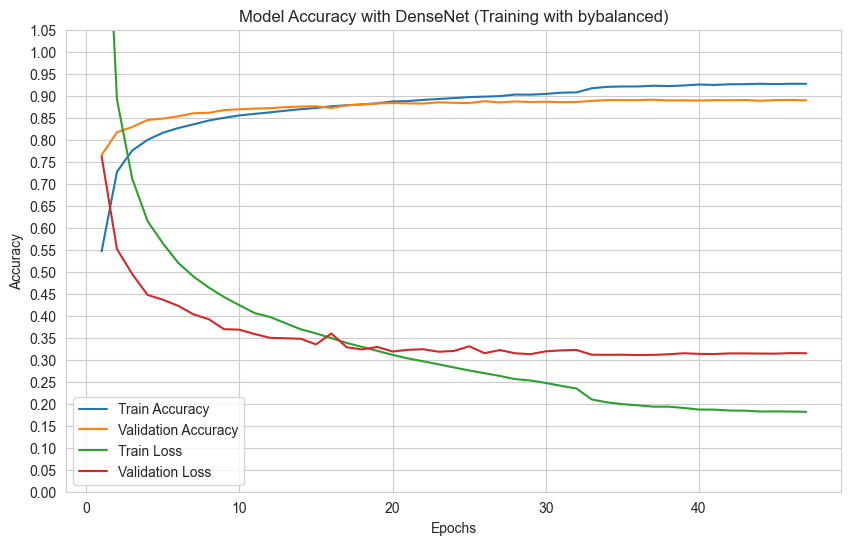

In [14]:
# 학습 결과 시각화
# Train 및 Validation Accuracy 데이터
train_accuracy = history_balance.history['accuracy']
val_accuracy = history_balance.history['val_accuracy']
train_loss = history_balance.history['loss']
val_loss = history_balance.history['val_loss']

# 그래프 생성
plt.figure(figsize=(10, 6))

# Train Accuracy 그래프
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')

# Validation Accuracy 그래프
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

plt.plot(range(1, len(train_accuracy) + 1), train_loss, label='Train Loss')

plt.plot(range(1, len(train_accuracy) + 1), val_loss, label='Validation Loss')
# 그래프 제목 및 축 레이블
plt.title('Model Accuracy with DenseNet (Training with bybalanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.ylim(0, 1)

plt.yticks(np.arange(0, 1.1, 0.05))

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

In [13]:
# Evaluate model
start_time = time.time()  # 추론 시작 시간
predictions = model.predict(test_x_balance)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(test_x_balance)

# 테스트 데이터에 대한 예측 결과 처리
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_y_balance, axis=1)

# 정확도 계산
correct_predictions = np.sum(predicted_classes == actual_classes)
accuracy = correct_predictions / len(predicted_classes)

# 결과 출력
print(f"Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {len(predicted_classes)}")
print(f"정확도: {accuracy:.4f}")
print(f"훈련시간 : {training_time:.2f} seconds.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.") #각 샘플에 대한 추론 시간을 개별적으로 측정함으로써, 추론에 필요한 시간을 더 정확히 파악

Correct Predictions: 16716
Total Predictions: 18799
정확도: 0.8892
훈련시간 : 477.71 seconds.
평균 추론 시간: 0.0000 seconds.



-------------------